<h1>NLP Assignment 2</h1>
<h3>Sirajahamed N D PES1201701496</h3>
<h3>Ajeya B S PES1201701604</h3>

In [1]:
import pandas as pd
import numpy as np
import regex as re
import unicodedata
from numpy import asarray
from numpy import zeros
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Dropout, Bidirectional,Activation,LSTM
from sklearn.preprocessing import OneHotEncoder
from pprint import pprint as pp
from nltk.corpus import stopwords
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
import string
import nltk
from nltk.classify import MaxentClassifier
from nltk.tokenize import sent_tokenize,word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
nltk.download('punkt')
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from nltk.classify.util import CutoffChecker, accuracy, log_likelihood

Using TensorFlow backend.
/home/ajeya/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ajeya/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ajeya/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ajeya/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [2]:
df = pd.read_csv("FinalTweetList.csv",header = None)

In [3]:
del df[2]

In [4]:
df[0] = df[0].astype('str')

In [5]:
df[0] = df[0].apply(lambda x: re.sub('^RT @','@',x))

In [6]:
df[0] = df[0].apply(lambda val: unicodedata.normalize('NFKD', val).encode('ascii', 'ignore').decode())
df[0] = df[0].apply(lambda val: val.lower())

In [7]:
banks = list(df[0].str.findall(r'@[a-zA-Z_0-9-]+'))


In [8]:
banks = [y for x in banks if len(x) != 0 for y in x]


In [9]:
unique_banks=set(banks)
bank_freq = list()
threshold = 2
for bank in unique_banks:
  if(banks.count(bank) > threshold):
    bank_freq.append([bank, banks.count(bank)])
bank_freq = sorted(bank_freq,key = lambda x : x[1], reverse=True)
print("Length of new list: ", len(bank_freq))

Length of new list:  196


In [10]:
bank_dict = dict()
bank_dict['hdfc_bank'] = ['@hdfcbanknews','@hdfc_bank','@hdfcbank_cares','@hdfclife','@hdfcbank','@neerajhdfcbank']
bank_dict['idbi_bank'] = ['@idbi_bank']
bank_dict['reserve_bank_of_india'] = ['@dasshaktikanta','@finminindia','@rbi']
bank_dict['sbi_bank'] = ['@sbicard_connect','@theofficialsbi','@sbi']
bank_dict['pnb_bank'] = ['@mdpnb','@indiapnb']
bank_dict['yes_bank'] = ['@yesbank']
bank_dict['kotak_bank'] = ['@udaykotak','@kotakbankltd','@anandmahindra','@kotakjifi']
bank_dict['axis_bank'] = ['axisbank','@axisbanksupport']
bank_dict['bank_of_baroda'] = ['@bankofbaroda','@bankofbarodaceo']
bank_dict['icici_bank'] = ['@icicibank','@icicibank_care','@icici_direct','@iciciprulife']
bank_dict['bank_of_india'] = ['@bankofindia_boi']
bank_dict['citi_bank'] = ['@citi','@citibank'] 
bank_dict['vijaya_bank'] = ['@vijayabankindia']
bank_dict['canara_bank'] = ['@canarabanktweet']
bank_dict['corportation_bank'] = ['@corpbanking']
bank_dict['union_bank'] = ['@unionbanktweets']
bank_dict['federal_bank'] = ['@federalbankltd']
bank_dict['central_bank'] = ['@centralbank_in']

In [11]:
count = 0
freq_tweets = dict()
for key in bank_dict.keys():
    for tweet in bank_dict[key]:
      count += banks.count(tweet)
    freq_tweets[key] = count
    count = 0
print(freq_tweets)

{'hdfc_bank': 1325, 'idbi_bank': 22, 'reserve_bank_of_india': 652, 'sbi_bank': 2518, 'pnb_bank': 36, 'yes_bank': 36, 'kotak_bank': 785, 'axis_bank': 565, 'bank_of_baroda': 276, 'icici_bank': 1353, 'bank_of_india': 10, 'citi_bank': 14, 'vijaya_bank': 7, 'canara_bank': 6, 'corportation_bank': 5, 'union_bank': 3, 'federal_bank': 3, 'central_bank': 3}


In [12]:
tags_for_each_tweet = list(df[0].str.findall(r'@[a-zA-Z_0-9-]+'))

In [13]:
threshold_count = 500
top_banks = list()
for key in freq_tweets.keys():
  if(freq_tweets[key] >= threshold_count):
    df[key] = [0 for x in range(len(df))]
    top_banks.append(key)
df['other'] = [0 for x in range(len(df))]

In [14]:
morebanks = dict()
sentbanks=[]
for key in bank_dict.keys():
  if key not in top_banks:
    if 'other' not in morebanks.keys(): 
        morebanks['other'] = bank_dict[key]
    morebanks['other'].extend(bank_dict[key])
  else:
    morebanks[key] = bank_dict[key]
print(morebanks.keys())

dict_keys(['hdfc_bank', 'other', 'reserve_bank_of_india', 'sbi_bank', 'kotak_bank', 'axis_bank', 'icici_bank'])


In [15]:
bankcomp=[0,0,0,0,0,0,0]
bankmisc=[0,0,0,0,0,0,0]
bankdisp=[0,0,0,0,0,0,0]
bankcomm=[0,0,0,0,0,0,0]

j=7
l=[]
for i in range(len(df)):
    tags = set(re.findall(r'@[a-zA-Z_0-9-]+', df[0][i]))
    for key in morebanks.keys():
        if len(set(tags).intersection(set(morebanks[key]))) >= 1:
            df[key][i] = 1
            
            if(key=="hdfc_bank"):
                l.append(2)
                bankcomm[2]+=1
            elif(key=="reserve_bank_of_india"):
                l.append(0)
                bankcomm[0]+=1
            elif(key=="sbi_bank"):
                l.append(1)
                bankcomm[1]+=1
            elif(key=="kotak_bank"):
                l.append(3)
                bankcomm[3]+=1
            elif(key=="icici_bank"):
                l.append(4)
                bankcomm[4]+=1
            elif(key=="axis_bank"):
                l.append(5)
                bankcomm[5]+=1
            else:
                l.append(6)
                bankcomm[6]+=1
        #print(j)
    senti=df[1][i]
        
    if(senti=="miscellaneous"):  
        for k in l:
            el=bankmisc[k]
            bankmisc[k]=el+1
    elif(senti=="compliment"):
        for k in l:
            el=bankcomp[k]
            bankcomp[k]=el+1
    else:
        for k in l:
            el=bankdisp[k]
            bankdisp[k]=el+1
    l=[]             

/home/ajeya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [16]:
df[0] = df[0].apply(lambda tweet: re.sub(r'@\S+|https?://\S+|\d|&[^ ]+|[^a-zA-Z ]|#\S+', '', tweet))

In [17]:
stop_words = set(stopwords.words('english'))
bankwords=[]
for i in df[0]:
    res=word_tokenize(i)
    filtered_sentence = [w for w in res if not w in stop_words] 
    bankwords.append(filtered_sentence)
    filtered_sentence = []

Percentage of compliments of  RBI bank =  8.056042031523642 %
Percentage of compliments of  SBI bank =  10.426731078904993 %
Percentage of compliments of  HDFC bank =  13.254113345521024 %
Percentage of compliments of  KOTAK bank =  21.751824817518248 %
Percentage of compliments of  ICICI bank =  13.167587476979742 %
Percentage of compliments of  AXIS bank =  6.73758865248227 %
Percentage of compliments of  OTHER bank =  16.0 %


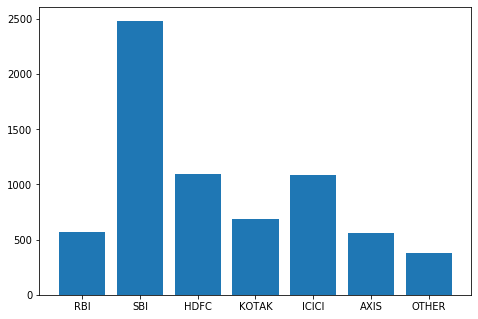

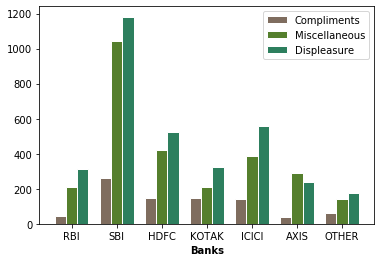

In [18]:
barWidth = 0.25
banklist=['RBI', 'SBI', 'HDFC', 'KOTAK', 'ICICI','AXIS','OTHER']
for i in range (0,7):
    print("Percentage of compliments of ",banklist[i],"bank = ",bankcomp[i]/(bankcomp[i]+bankdisp[i]+bankmisc[i])*100,"%")
r1 = np.arange(len(bankcomp))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(banklist,bankcomm)
plt.show()
plt.bar(r1, bankcomp, color='#7f6d5f', width=barWidth, edgecolor='white', label='Compliments')
plt.bar(r2, bankmisc, color='#557f2d', width=barWidth, edgecolor='white', label='Miscellaneous')
plt.bar(r3, bankdisp, color='#2d7f5e', width=barWidth, edgecolor='white', label='Displeasure')
plt.xlabel('Banks', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bankcomp))],banklist)
plt.legend()
plt.show()

<h5>For the visualization section, we make use of bar graphs, one for total count of tweets and the other, a grouped bar chart- for the segregation of comments into 3 categories .
From the initial bar cahrt,we see that SBI bank has the highest number of tweets. 
From the second bank, we see that the all banks have high number of tweets towards displeasure , and KOTAK bank has the highest ratio of positive comments.
</h5>

In [19]:
def word_feats(words):
    return dict([(word[0],word[1]) for word in words])

In [20]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
bankwords1=[]
for i in range(0,2847):
    res=word_tokenize(df[0][i])
    filtered_sentence = [w for w in res if not w in stop_words]
    filtered_sentence = nltk.pos_tag(filtered_sentence)
    bankwords1.append(filtered_sentence)
    filtered_sentence = []

features = []
count = 0
for words in bankwords1:
    features.append((word_feats(words),df[1][count]))
    count += 1
print(features)

[({'bank': 'NN', 'employees': 'NNS', 'c': 'VBP', 'faridabad': 'JJ', 'making': 'NN', 'fools': 'NNS', 'customers': 'NNS', 'helping': 'VBG', 'giving': 'VBG', 'nonsense': 'JJ', 'excusesbetter': 'NN', 'learn': 'NN'}, 'displeasure'), ({'permanently': 'RB', 'busy': 'JJ', 'go': 'VBP', 'beyond': 'IN', 'language': 'NN', 'selectionwhat': 'RB', 'kind': 'NN', 'support': 'NN'}, 'displeasure'), ({'hours': 'NNS', 'linestill': 'VBP', 'waiting': 'VBG', 'wish': 'JJ', 'ur': 'JJ', 'staff': 'NN', 'cld': 'NN', 'work': 'NN', 'efficiently': 'RB'}, 'displeasure'), ({'atm': 'NN', 'machines': 'NNS', 'times': 'NNS', 'india': 'VBP', 'noida': 'JJ', 'office': 'NN', 'unable': 'JJ', 'dispense': 'NN', 'cash': 'NN', 'please': 'NN', 'resolve': 'VB', 'asap': 'NN'}, 'displeasure'), ({'thanks': 'NNS', 'icici': 'VBP', 'bank': 'NN', 'got': 'VBD', 'case': 'NN', 'atm': 'NN', 'totally': 'RB', 'bad': 'JJ', 'experience': 'NN'}, 'miscellaneous'), ({'assam': 'JJ', 'banks': 'NNS', 'exchanging': 'VBG', 'exchanged': 'VBD', 'yesterday': 

In [21]:
algorithm = nltk.classify.MaxentClassifier.ALGORITHMS[0]
classifier = nltk.MaxentClassifier.train(features,algorithm,max_iter=10)
Accuracyme=nltk.classify.util.accuracy(classifier,features)
print(Accuracyme)

  ==> Training (10 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.391
             2          -1.09783        0.830
             3          -1.09705        0.830
             4          -1.09627        0.830
             5          -1.09550        0.830
             6          -1.09472        0.830
             7          -1.09395        0.831
             8          -1.09317        0.831
             9          -1.09240        0.831
         Final          -1.09163        0.831
0.8306989813839128


In [22]:

stop_words = set(stopwords.words('english'))
bankwords2=[]
for i in range(2848,5694):
    res=word_tokenize(df[0][i])
    filtered_sentence = [w for w in res if not w in stop_words]
    bankwords2.append(filtered_sentence)
    filtered_sentence = []



In [ ]:
embeddings = dict()
f = open('glove.6B.300d.txt',encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings[word] = coefs
f.close()

163682it [00:39, 2355.17it/s]

In [ ]:
t = Tokenizer()
t.fit_on_texts(bankwords2)
encoded_docs = t.texts_to_sequences(bankwords2)
X = pad_sequences(encoded_docs, padding='post')

In [ ]:
vocab_size = len(set([word for words in bankwords2 for word in words]))

In [ ]:
embedding_matrix = zeros((vocab_size+1, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
print(X.shape)
y = df[1][count:df[1].shape[0]-1]
onehotencoder = OneHotEncoder() 
y = onehotencoder.fit_transform(y.to_numpy().reshape(-1,1)).toarray()
print(y.shape)

In [ ]:

model = Sequential()
model.add(Embedding(vocab_size+1,300,weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='sigmoid'))
model.add(Activation('softmax'))
model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.3,random_state=42)
model.fit(X_train, y_train, batch_size = 64, epochs = 3, validation_data=(X_val,y_val))
Loss,Accuracydl = model.evaluate(X_test,y_test)

In [ ]:
print("Loss :- ",Loss,"Accuracy :- ",Accuracydl)

In [ ]:
print((Accuracyme+Accuracydl)/2)

For the hybrid model, we are combining the two in such a way that half of the tweets are sent to maxent classifier, and the other half to LSTM model. The result of the hybrid model is the combination of both. The resultant accuracy is 75%. 